# Bikeshare & the Built Environment
This Python notebook contains scripts used to subset and aggregate data for multiple regression analyses
## Set Up

In [2]:
import requests, zipfile, io, pandas as pd, seaborn as sns, numpy as np, geopandas as gpd, matplotlib.pyplot as plt
from shapely.geometry import point

## Import cleaned trip data

In [3]:
df = pd.read_csv('../Data_Clean/trips_cleaned_new.csv')
df = df.rename(columns={"start station id": "start_id", "end station id": "end_id"}).drop(df.columns[[0,1]], axis=1)

In [4]:
stations = pd.read_csv('../Data_Clean/station_locations.csv')

## Aggregate trips by station location

In [5]:
station_list = pd.DataFrame(stations['station id'].unique())
station_list = station_list.rename(columns={0:'station_id'})
len(station_list)

381

In [6]:
def trips_by_station(df): 
    departures_df = df.groupby('start_id').agg({'gender':'count'}).reset_index().rename(columns = {'gender':'departures'})
    arrivals_df = df.groupby('end_id').agg({'gender':'count'}).reset_index().rename(columns = {'gender':'arrivals'})
    female_departures = df[df['gender']=='female'].groupby('start_id').agg({'gender':'count'}).rename(columns = {'gender':'female_departures'}).reset_index()
    female_arrivals = df[df['gender']=='female'].groupby('end_id').agg({'gender':'count'}).rename(columns = {'gender':'female_arrivals'}).reset_index()
    male_departures = df[df['gender']=='male'].groupby('start_id').agg({'gender':'count'}).rename(columns = {'gender':'male_departures'}).reset_index()
    male_arrivals = df[df['gender']=='male'].groupby('end_id').agg({'gender':'count'}).rename(columns = {'gender':'male_arrivals'}).reset_index()
    arrivals_df = arrivals_df.merge(female_arrivals)
    arrivals_df = arrivals_df.merge(male_arrivals)
    arrivals_df['arrival_trip_parity'] = arrivals_df.female_arrivals/arrivals_df.male_arrivals
    departures_df = departures_df.merge(female_departures)
    departures_df = departures_df.merge(male_departures)
    departures_df['departure_trip_parity'] = departures_df.female_departures/departures_df.male_departures
    df2 = station_list.merge(arrivals_df, how='left', right_on='end_id', left_on='station_id').reset_index(drop=True)
    df3 = df2.merge(departures_df, how='left', right_on='start_id', left_on='station_id')
    df4 = df3.drop(columns=["end_id", 'start_id'])
    return df4

In [7]:
trips_sorted = trips_by_station(df)

In [8]:
trips_1000 = trips_sorted[trips_sorted.arrivals > 1000]

In [9]:
trips_1000[['arrivals', 'arrival_trip_parity', 'departures', 'departure_trip_parity']].describe()
#data is right skewed with the mean greater than the median for trip arrivals, departures, and parity rates 

,arrivals,arrival_trip_parity,departures,departure_trip_parity
count,278.000000,278.000000,278.000000,278.000000
mean,24211.812950,0.368998,24206.446043,0.377355
std,27826.942056,0.100190,27411.693343,0.111478
min,1013.000000,0.118130,836.000000,0.137830
25%,4226.250000,0.301410,4271.250000,0.291582
50%,13237.500000,0.359660,13682.000000,0.367002
75%,37772.500000,0.421221,37322.750000,0.440739
max,184522.000000,0.673058,190922.000000,0.787037


In [10]:
trips_sorted.to_csv('../Data_Clean/trips_sorted.csv', index=False)

In [11]:
len(trips_1000)

278

In [ ]:
trips_1000.to_csv('../Data_Clean/trips_sorted_1000.csv', index=False)

## Create geoframe for stations with 1,000 trips or more 

In [12]:
stations.head()

,station id,station name,latitude,longitude
0,115,Porter Square Station,42.387995,-71.119084
1,80,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156
2,91,One Kendall Square at Hampshire St / Portland St,42.366277,-71.091690
3,105,Lower Cambridgeport at Magazine St / Riverside Rd,42.357219,-71.113872
4,88,Inman Square at Vellucci Plaza / Hampshire St,42.374035,-71.101427


In [13]:
stations_1000 = stations[stations['station id'].isin(trips_1000.station_id)]

In [14]:
len(stations_1000)

278

In [15]:
stations_1000.to_csv('../Data_Clean/station_locations_1000.csv', index=False)

In [24]:
stations_gdf = gpd.GeoDataFrame(stations_1000, 
                                  geometry=gpd.points_from_xy(stations_1000.longitude, stations_1000.latitude))

<AxesSubplot:>

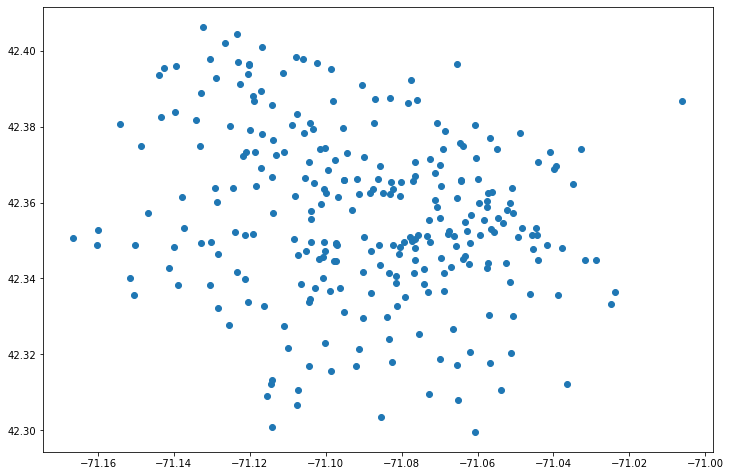

In [25]:
stations_gdf.plot(figsize=(12,12))

In [27]:
stations_gdf = stations_gdf.set_crs(epsg=26986)

<AxesSubplot:>

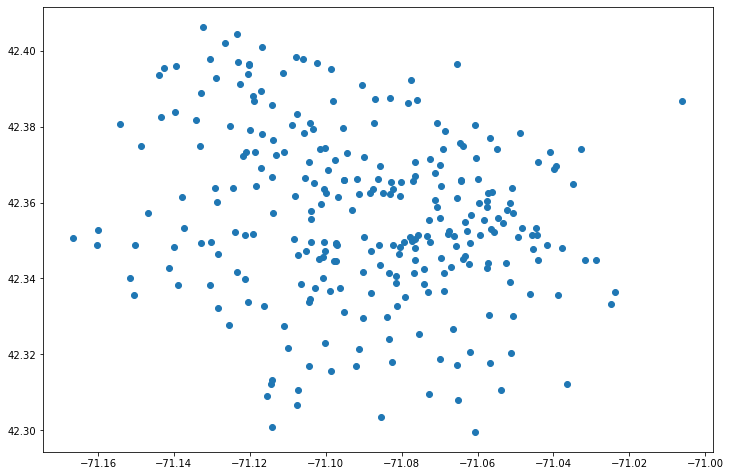

In [28]:
stations_gdf.plot(figsize=(12,12))

In [29]:
stations_gdf.to_file("../Data_Clean/station_locations.shp")

C:\Users\casey\AppData\Local\Temp\ipykernel_13524\2888403990.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  stations_gdf.to_file("../Data_Clean/station_locations.shp")


### Create dataframe with trips only at 278 stations

In [45]:
#create new trips df for stations with 1000+ trips 
trips = df[df.start_id.isin(station_list.station_id)]

In [46]:
trips.to_csv('../Data_Clean/trips_cleaned_1000.csv', index=False)

In [24]:
len(df)-len(trips)

450